## **Building Random Forest using CAPM ans Fama French Models**

# **CAPM and FF**

In [ ]:
#importing libs
import pandas as pd
import numpy as np 

import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col 

price2ret: This converts prices to arithmetic or log returns.


assetPriceReg: By giving a dataframe of stock with a column named Returns, the function extracts the risk factor returns from web and runs a CAPM, FF3, and FF5 regression

In [ ]:
def price2ret(prices,retType='simple'):
    if retType == 'simple':
        ret = (prices/prices.shift(1))-1
    else:
        ret = np.log(prices/prices.shift(1))
    return ret

In [ ]:
def assetPriceReg(ms):
    import pandas_datareader.data as web 
    
    # Reading in factor data
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT']/100
    df_factors['SMB'] = df_factors['SMB']/100
    df_factors['HML'] = df_factors['HML']/100
    df_factors['RMW'] = df_factors['RMW']/100
    df_factors['CMA'] = df_factors['CMA']/100
    
    df_stock_factor = pd.merge(ms,df_factors,left_index=True,right_index=True) 
    df_stock_factor['XsRet'] = df_stock_factor['Returns'] - df_stock_factor['RF'] 

    # Running CAPM, FF3, and FF5 models.
    CAPM = smf.ols(formula = 'XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF3 = smf.ols( formula = 'XsRet ~ MKT + SMB + HML', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF5 = smf.ols( formula = 'XsRet ~ MKT + SMB + HML + RMW + CMA', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    CAPMtstat = CAPM.tvalues
    FF3tstat = FF3.tvalues
    FF5tstat = FF5.tvalues

    CAPMcoeff = CAPM.params
    FF3coeff = FF3.params
    FF5coeff = FF5.params

    # DataFrame with coefficients and t-stats
    results_df = pd.DataFrame({'CAPMcoeff':CAPMcoeff,'CAPMtstat':CAPMtstat,
                               'FF3coeff':FF3coeff, 'FF3tstat':FF3tstat,
                               'FF5coeff':FF5coeff, 'FF5tstat':FF5tstat},
    index = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])


    dfoutput = summary_col([CAPM,FF3, FF5],stars=True,float_format='%0.4f',
                  model_names=['CAPM','FF3','FF5'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adjusted R2':lambda x: "{:.4f}".format(x.rsquared_adj)}, 
                             regressor_order = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    print(dfoutput)
    
    return results_df

Reading in MS stock data



In [ ]:
from pathlib import Path
import sys
import os
import pandas_datareader.data as web
from pandas import Series, DataFrame

%matplotlib inline

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import datetime

start = datetime.datetime(2019,1,1)
end = datetime.datetime(2019,8,31)

ms = web.DataReader("MS", 'yahoo', start, end)
ms.shape
 


(168, 6)

In [ ]:
ms.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,40.720001,38.759998,39.020000,40.400002,10648000.0,38.113232
2019-01-03,40.220001,39.250000,40.220001,39.680000,13034500.0,37.433983
2019-01-04,41.580002,40.279999,40.500000,41.299999,14371600.0,38.962288
2019-01-07,42.160000,40.980000,41.509998,41.709999,11812400.0,39.349075
2019-01-08,42.410000,41.080002,42.299999,41.450001,11398200.0,39.103790


applying the price to return function on 'Adj Close' and dropped nas and the information is shown below

In [ ]:
ms['Returns'] = price2ret(ms[['Adj Close']])
ms = ms.dropna()
ms.tail()

,High,Low,Open,Close,Volume,Adj Close,Returns
Date,,,,,,,
2019-08-26,40.270000,39.700001,39.840000,40.160000,10408600.0,38.696182,0.021103
2019-08-27,40.340000,39.450001,40.250000,39.790001,8742900.0,38.339672,-0.009213
2019-08-28,40.700001,39.349998,39.400002,40.380001,9881900.0,38.908165,0.014828
2019-08-29,41.500000,40.869999,40.889999,41.290001,12191900.0,39.785000,0.022536
2019-08-30,41.869999,41.299999,41.680000,41.490002,7427000.0,39.977707,0.004844


we plot returns against date columns and observe the pattern

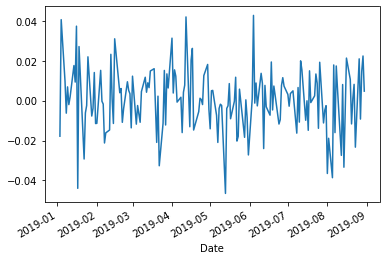

In [ ]:
ms['Returns'].plot()

Similarly a distribution plot has been plotted for returns which shows that the dist is normal

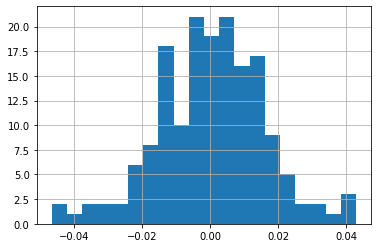

In [ ]:
ms['Returns'].hist(bins=20)

Running risk factor regressions

In [ ]:
df_regOutput = assetPriceReg(ms)


               CAPM       FF3        FF5    
--------------------------------------------
Intercept   -0.0098*** -0.0090*** -0.0090***
            (0.0008)   (0.0007)   (0.0006)  
MKT         1.2407***  1.4062***  1.1715*** 
            (0.0774)   (0.0829)   (0.0776)  
SMB                    -0.2346*   -0.3124***
                       (0.1233)   (0.1129)  
HML                    1.1569***  1.5770*** 
                       (0.1268)   (0.1403)  
RMW                               -0.1696   
                                  (0.2019)  
CMA                               -1.6938***
                                  (0.2958)  
N           167        167        167       
Adjusted R2 0.5208     0.6739     0.7358    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [ ]:
df_regOutput

,CAPMcoeff,CAPMtstat,FF3coeff,FF3tstat,FF5coeff,FF5tstat
Intercept,-0.009798,-12.710190,-0.009042,-13.642200,-0.009016,-15.953896
MKT,1.240662,16.021922,1.406173,16.955458,1.171499,15.105221
SMB,NaN,NaN,-0.234579,-1.902155,-0.312395,-2.766038
HML,NaN,NaN,1.156920,9.124379,1.576986,11.239008
RMW,NaN,NaN,NaN,NaN,-0.169604,-0.839900
CMA,NaN,NaN,NaN,NaN,-1.693802,-5.726844


# Building Random Forest

Data has been loaded and required columns are scaled dividing by 100.The column MKT-RF has been renamed to MKT

In [ ]:
    # Reading in factor data
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT']/100
    df_factors['SMB'] = df_factors['SMB']/100
    df_factors['HML'] = df_factors['HML']/100
    df_factors['RMW'] = df_factors['RMW']/100
    df_factors['CMA'] = df_factors['CMA']/100

In [ ]:
df_factors

,MKT,SMB,HML,RMW,CMA,RF
Date,,,,,,
2015-12-14,0.0029,-0.0113,-0.0018,0.0014,-0.0034,0.0
2015-12-15,0.0110,0.0019,0.0082,-0.0081,0.0012,0.0
2015-12-16,0.0147,0.0002,-0.0065,-0.0010,-0.0016,0.0
2015-12-17,-0.0146,0.0030,-0.0034,-0.0023,-0.0009,0.0
2015-12-18,-0.0170,0.0069,-0.0038,-0.0027,0.0017,0.0
...,...,...,...,...,...,...
2020-10-26,-0.0185,-0.0045,-0.0040,-0.0004,0.0005,0.0
2020-10-27,-0.0023,-0.0058,-0.0238,-0.0027,-0.0073,0.0
2020-10-28,-0.0342,0.0022,0.0055,-0.0049,0.0001,0.0


Merge two datasets namely ms, df_factors using merge operation where the kind is inner merge.
We drop the returns column 'Returns'
And perform renaming column 'MKT' -> 'MKt-RF'

In [ ]:
merge=pd.merge(ms, df_factors, how='inner', left_index=True, right_index=True)
merge = merge.drop(['Returns'], axis=1)
merge = merge.rename({'MKT': 'MKt-RF'}, axis = 1)
merge

,High,Low,Open,Close,Volume,Adj Close,MKt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,,,,
2019-01-03,40.220001,39.250000,40.220001,39.680000,13034500.0,37.433983,-0.0245,0.0052,0.0126,-0.0025,0.0091,0.010
2019-01-04,41.580002,40.279999,40.500000,41.299999,14371600.0,38.962288,0.0355,0.0038,-0.0072,-0.0008,-0.0058,0.010
2019-01-07,42.160000,40.980000,41.509998,41.709999,11812400.0,39.349075,0.0094,0.0084,-0.0078,-0.0069,-0.0041,0.010
2019-01-08,42.410000,41.080002,42.299999,41.450001,11398200.0,39.103790,0.0101,0.0045,-0.0064,0.0036,-0.0009,0.010
2019-01-09,42.209999,41.250000,41.910000,41.740002,9223000.0,39.377380,0.0056,0.0050,0.0006,0.0010,-0.0018,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,40.270000,39.700001,39.840000,40.160000,10408600.0,38.696182,0.0108,-0.0003,-0.0019,0.0019,-0.0013,0.007
2019-08-27,40.340000,39.450001,40.250000,39.790001,8742900.0,38.339672,-0.0046,-0.0100,-0.0068,0.0026,0.0009,0.007
2019-08-28,40.700001,39.349998,39.400002,40.380001,9881900.0,38.908165,0.0068,0.0064,0.0061,0.0042,0.0019,0.007


We now import the required libraries as below

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
from sklearn.metrics import mean_squared_error

 Perform aggregations such as average, no of days, diff_open, diff_close etc. Here 'Close' which is our Y has been named as lable

In [ ]:

df = merge
df = df.reset_index()

df["Average"] = (df["Open"] + 2*df["High"] + df["Close"])/4
df["Days"] = range(1,df.shape[0]+1)
df["diff_Open"] = (df.Open - df.Open.shift(periods=1))
df["diff_Close"] = (df.Close - df.Close.shift(periods=1))
df["diff_RMW"] = (df.RMW - df.RMW.shift(periods=1))
df["diff_SMB"] = (df.SMB - df.SMB.shift(periods=1))
df["diff_MktRF"] = (df["MKt-RF"] - df["MKt-RF"].shift(periods=1))
df["diff_HML"] = (df.HML - df.HML.shift(periods=1))
df["diff_CMA"] = (df.CMA - df.CMA.shift(periods=1))
df["diff_Average"] = (df.Average - df.Average.shift(periods=1))
df = df.dropna().reset_index(drop=True)
df["label"] = df.diff_Close
df = df.drop("diff_Close", axis=1)
df

,Date,High,Low,Open,Close,Volume,Adj Close,MKt-RF,SMB,HML,RMW,CMA,RF,Average,Days,diff_Open,diff_RMW,diff_SMB,diff_MktRF,diff_HML,diff_CMA,diff_Average,label
0,2019-01-04,41.580002,40.279999,40.500000,41.299999,14371600.0,38.962288,0.0355,0.0038,-0.0072,-0.0008,-0.0058,0.010,41.240001,2,0.279999,0.0017,-0.0014,0.0600,-0.0198,-0.0149,1.155000,1.619999
1,2019-01-07,42.160000,40.980000,41.509998,41.709999,11812400.0,39.349075,0.0094,0.0084,-0.0078,-0.0069,-0.0041,0.010,41.884999,3,1.009998,-0.0061,0.0046,-0.0261,-0.0006,0.0017,0.644999,0.410000
2,2019-01-08,42.410000,41.080002,42.299999,41.450001,11398200.0,39.103790,0.0101,0.0045,-0.0064,0.0036,-0.0009,0.010,42.142500,4,0.790001,0.0105,-0.0039,0.0007,0.0014,0.0032,0.257501,-0.259998
3,2019-01-09,42.209999,41.250000,41.910000,41.740002,9223000.0,39.377380,0.0056,0.0050,0.0006,0.0010,-0.0018,0.010,42.017500,5,-0.389999,-0.0026,0.0005,-0.0045,0.0070,-0.0009,-0.125000,0.290001
4,2019-01-10,41.959999,41.240002,41.380001,41.660000,7560800.0,39.301907,0.0042,-0.0001,-0.0047,-0.0006,-0.0004,0.010,41.740000,6,-0.529999,-0.0016,-0.0051,-0.0014,-0.0053,0.0014,-0.277500,-0.080002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2019-08-26,40.270000,39.700001,39.840000,40.160000,10408600.0,38.696182,0.0108,-0.0003,-0.0019,0.0019,-0.0013,0.007,40.135000,163,-0.209999,0.0085,0.0058,0.0374,-0.0001,0.0015,0.089999,0.829998
162,2019-08-27,40.340000,39.450001,40.250000,39.790001,8742900.0,38.339672,-0.0046,-0.0100,-0.0068,0.0026,0.0009,0.007,40.180000,164,0.410000,0.0007,-0.0097,-0.0154,-0.0049,0.0022,0.045000,-0.369999
163,2019-08-28,40.700001,39.349998,39.400002,40.380001,9881900.0,38.908165,0.0068,0.0064,0.0061,0.0042,0.0019,0.007,40.295001,165,-0.849998,0.0016,0.0164,0.0114,0.0129,0.0010,0.115001,0.590000
164,2019-08-29,41.500000,40.869999,40.889999,41.290001,12191900.0,39.785000,0.0135,0.0042,0.0033,0.0019,-0.0012,0.007,41.295000,166,1.489998,-0.0023,-0.0022,0.0067,-0.0028,-0.0031,0.999999,0.910000


Below are the new columns introduced

In [ ]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'MKt-RF',
       'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Average', 'Days', 'diff_Open',
       'diff_RMW', 'diff_SMB', 'diff_MktRF', 'diff_HML', 'diff_CMA',
       'diff_Average', 'label'],
      dtype='object')

Now we modify the data by dropping "label" remove "na" and reset the index for df_x and manipulations such as dropna(), reser_index on df_y i.e taget column and merge both and stored in as modified_df 


In [ ]:
df_x = df.drop("label", axis =1).shift(periods=1).dropna().reset_index(drop=True)
df_y = df[["label"]].shift(periods=-1).dropna().reset_index(drop=True)
modified_df = pd.concat([df_x,df_y], axis =1)

modified_df


,Date,High,Low,Open,Close,Volume,Adj Close,MKt-RF,SMB,HML,RMW,CMA,RF,Average,Days,diff_Open,diff_RMW,diff_SMB,diff_MktRF,diff_HML,diff_CMA,diff_Average,label
0,2019-01-04,41.580002,40.279999,40.500000,41.299999,14371600.0,38.962288,0.0355,0.0038,-0.0072,-0.0008,-0.0058,0.010,41.240001,2.0,0.279999,0.0017,-0.0014,0.0600,-0.0198,-0.0149,1.155000,0.410000
1,2019-01-07,42.160000,40.980000,41.509998,41.709999,11812400.0,39.349075,0.0094,0.0084,-0.0078,-0.0069,-0.0041,0.010,41.884999,3.0,1.009998,-0.0061,0.0046,-0.0261,-0.0006,0.0017,0.644999,-0.259998
2,2019-01-08,42.410000,41.080002,42.299999,41.450001,11398200.0,39.103790,0.0101,0.0045,-0.0064,0.0036,-0.0009,0.010,42.142500,4.0,0.790001,0.0105,-0.0039,0.0007,0.0014,0.0032,0.257501,0.290001
3,2019-01-09,42.209999,41.250000,41.910000,41.740002,9223000.0,39.377380,0.0056,0.0050,0.0006,0.0010,-0.0018,0.010,42.017500,5.0,-0.389999,-0.0026,0.0005,-0.0045,0.0070,-0.0009,-0.125000,-0.080002
4,2019-01-10,41.959999,41.240002,41.380001,41.660000,7560800.0,39.301907,0.0042,-0.0001,-0.0047,-0.0006,-0.0004,0.010,41.740000,6.0,-0.529999,-0.0016,-0.0051,-0.0014,-0.0053,0.0014,-0.277500,0.080002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2019-08-23,40.400002,39.110001,40.049999,39.330002,12310800.0,37.896439,-0.0266,-0.0061,-0.0018,-0.0066,-0.0028,0.007,40.045001,162.0,-0.310001,-0.0084,-0.0024,-0.0256,-0.0069,-0.0055,-0.322498,0.829998
161,2019-08-26,40.270000,39.700001,39.840000,40.160000,10408600.0,38.696182,0.0108,-0.0003,-0.0019,0.0019,-0.0013,0.007,40.135000,163.0,-0.209999,0.0085,0.0058,0.0374,-0.0001,0.0015,0.089999,-0.369999
162,2019-08-27,40.340000,39.450001,40.250000,39.790001,8742900.0,38.339672,-0.0046,-0.0100,-0.0068,0.0026,0.0009,0.007,40.180000,164.0,0.410000,0.0007,-0.0097,-0.0154,-0.0049,0.0022,0.045000,0.590000
163,2019-08-28,40.700001,39.349998,39.400002,40.380001,9881900.0,38.908165,0.0068,0.0064,0.0061,0.0042,0.0019,0.007,40.295001,165.0,-0.849998,0.0016,0.0164,0.0114,0.0129,0.0010,0.115001,0.910000


Below we have given required train and test , start and end dates respectively now we chop the required data according to start and end date and take in required columns such as Close, volume, rf, diff_close,diff_RMW etc

In [ ]:
train_start_date = "2019-01-04"
train_end_date =  "2019-07-15"
test_start_date = "2019-07-16"
test_end_date = "2019-08-29"
df_tr = df[(df["Date"] >= train_start_date) & (df["Date"] <= train_end_date)]
df_tst = df[(df["Date"] >= test_start_date) & (df["Date"] <= test_end_date)]
df_train = df_tr[["Close","Volume","RF","diff_Open","diff_RMW","diff_SMB","diff_MktRF","diff_HML","diff_CMA","diff_Average","label"]]
df_test = df_tst[["Close","Volume","RF","diff_Open","diff_RMW","diff_SMB","diff_MktRF","diff_HML","diff_CMA","diff_Average","label"]]

In [ ]:
df_train.head()

,Close,Volume,RF,diff_Open,diff_RMW,diff_SMB,diff_MktRF,diff_HML,diff_CMA,diff_Average,label
0,41.299999,14371600.0,0.01,0.279999,0.0017,-0.0014,0.0600,-0.0198,-0.0149,1.155000,1.619999
1,41.709999,11812400.0,0.01,1.009998,-0.0061,0.0046,-0.0261,-0.0006,0.0017,0.644999,0.410000
2,41.450001,11398200.0,0.01,0.790001,0.0105,-0.0039,0.0007,0.0014,0.0032,0.257501,-0.259998
3,41.740002,9223000.0,0.01,-0.389999,-0.0026,0.0005,-0.0045,0.0070,-0.0009,-0.125000,0.290001
4,41.660000,7560800.0,0.01,-0.529999,-0.0016,-0.0051,-0.0014,-0.0053,0.0014,-0.277500,-0.080002


In [ ]:
df_test.head()

,Close,Volume,RF,diff_Open,diff_RMW,diff_SMB,diff_MktRF,diff_HML,diff_CMA,diff_Average,label
132,44.430000,10170900.0,0.009,-0.209999,0.0034,0.0090,-0.0028,0.0113,-0.0028,-0.027498,0.000000
133,43.770000,9131800.0,0.009,-0.540001,-0.0098,-0.0066,-0.0032,-0.0078,-0.0020,-0.670001,-0.660000
134,44.430000,11187500.0,0.009,-0.590000,0.0017,-0.0002,0.0099,0.0064,0.0062,0.117500,0.660000
135,44.389999,10083600.0,0.009,0.680000,0.0070,0.0059,-0.0091,0.0087,-0.0023,0.254999,-0.040001
136,44.500000,7091800.0,0.009,-0.129997,-0.0058,-0.0084,0.0081,-0.0134,-0.0016,-0.059999,0.110001


Below is a function which checks the purity such as unique values returns true if the len(unique_class) is 1 else false

In [ ]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)
    if len(unique_classes) == 1:
        return True
    else:
        return False

The below function creates leaf node which is the mean of the column and returns the value

In [ ]:
def create_leaf(data):
    label_column = data[:, -1]
    leaf = np.mean(label_column)
    return leaf

The get_potential_splits is used to split a random space and return the required potential split of data 

In [ ]:
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    
    column_indices = list(range(n_columns-1))       
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
        
    return potential_splits

split data functions splits the columns as follows if the type_of_feature is "continuous" 
then we have data_below consisting split_column_values <= split_value and data_above as split_column_values> split_value
if the feature is categorical our split is as follows data_below
has split_col_value == split_value else != split_value and required data is returned from the function

In [ ]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

we need measure our model performance in this case we use calculate_mse in order to calculate mean square error on data there are two conditions
if actual_values are zero then there is no comparision among predicted and actual hence mse = 0 
else we formulate mse as mean_square of difference of actual and predicted

In [ ]:
def calculate_mse(data):
    
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

Now we need to caluclate the overall_performance of both above and below data which is as follows
we use weighted sum of data and metrics and return overall_value

In [ ]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In order to determine the best split we use the below function which describes the best split by considering the amount of mse or metrics returns due to the specific split . This in turn returns the best split whihc has least error 

In [ ]:
def determine_best_split(data, potential_splits):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

This function  checks whether a feature (except label) is categorical or continuous 

In [ ]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

Bootstrapping is used for randomization where we provide bootstrap length and the indices are assigned randomly 
and required bootstrapped data will be returned as df_bootstrapped

In [ ]:
def bootstrapping(train_df, n_bootstrap):
    
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

Decision_tree method takes in counter, datatset, min_samples, max_depth and random_subspace if the counter which acts like flag is set to zero which is our first iteration the data is taken in and from counter > 0 the df is assigned to data variable , the required checks such as purity, best_split, etc are used and sub_tree is returned 

In [ ]:
def decision_tree_algorithm(df, counter=0, min_samples=5, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If yes_answer = no_answer
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

Now we apply bootstrapping on random tree and return random_forest on dataset

In [ ]:
def random_forest_algorithm(df_train, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(df_train, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

we fit our model with an example 

In [ ]:
def predict_example(example, tree):
    record = list()
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

decision tree predictions are performed on test data 

In [ ]:
def decision_tree_predictions(df_test, tree):
    predictions = df_test.apply(predict_example, args=(tree,), axis=1)
    return predictions

random_forest_predictions are performed on test data as follows

In [ ]:
def random_forest_predictions(df_test, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(df_test, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

Performance metrics such as r_squared, rmse are calculated below:

In [ ]:
def calculate_r_squared(predictions, labels):    
    mean = labels.mean()
    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

In [ ]:
def calculate_rmse(predictions, labels):
    mse = mean_squared_error(labels,predictions)
    rmse = np.sqrt(mse)
    return rmse

A plot is built between actuals and predictions as follows

In [ ]:
def create_plot(predictions, labels, title):    
    plot_df = pd.DataFrame({"actual": labels, "predictions": predictions})
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

In [ ]:
grid_search = {"max_depth": [], "trees": [], "rmse_test": [], "r_squared_test": [], "bootstrap": [] }
for max_depth in range(1, 7):
    for trees in range(1,10):
        for bootstrap in range(25,225,25):
            forest = random_forest_algorithm(df_train, n_trees=trees, n_bootstrap= bootstrap, n_features=3, dt_max_depth=max_depth)
            delta_Close_pred = random_forest_predictions(df_test, forest)
            df_pred = pd.DataFrame(list(zip(delta_Close_pred,df_test.label.values, df_test.Close.values)), columns = ["predictions","Actual","Close_Act"])
            df_pred["Close_pred"] = df_pred.predictions + df_test.Close.shift(1).reset_index(drop=True)
            df_pred = df_pred.dropna().reset_index(drop=True)

            rmse_test = calculate_rmse(list(df_pred.Close_pred.values), list(df_pred.Close_Act.values))
            r_squared_test = calculate_r_squared(df_pred.Close_pred, df_pred.Close_Act)

            grid_search["max_depth"].append(max_depth)
            grid_search["trees"].append(trees)
            grid_search["bootstrap"].append(bootstrap)
            grid_search["rmse_test"].append(rmse_test)
            grid_search["r_squared_test"].append(r_squared_test)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_test", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,trees,rmse_test,r_squared_test,bootstrap
367,6,1,0.397715,0.966883,200
235,4,3,0.466761,0.954386,100
291,5,1,0.466963,0.954346,100
309,5,3,0.476462,0.952470,150
375,6,2,0.479282,0.951905,200


In [ ]:
forest = random_forest_algorithm(df_train, n_trees=2, n_bootstrap= 75, n_features=3, dt_max_depth=5)
delta_Close_pred = random_forest_predictions(df_test, forest)
df_pred = pd.DataFrame(list(zip(delta_Close_pred,df_test.label.values, df_test.Close.values)), columns = ["predictions","Actual","Close_Act"])
df_pred["Close_pred"] = df_pred.predictions + df_test.Close.shift(1).reset_index(drop=True)
df_pred = df_pred.dropna().reset_index(drop=True)

rmse_test = calculate_rmse(list(df_pred.Close_pred.values), list(df_pred.Close_Act.values))
r_squared_test = calculate_r_squared(df_pred.Close_pred, df_pred.Close_Act)
    
print("RMSE value of best possible solution: ",rmse_test)
print("R2 value of best possible solution: ",r_squared_test)


RMSE value of best possible solution:  0.554984874631505
R2 value of best possible solution:  0.9355125260761344


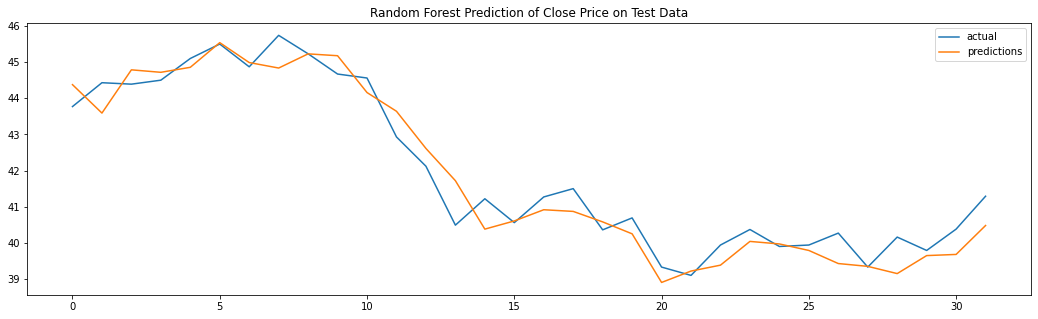

In [ ]:
create_plot(list(df_pred.Close_pred.values), list(df_pred.Close_Act.values), title="Random Forest Prediction of Close Price on Test Data")